RECOMMENDATION SYSTEM - 3

Step 1: Install requirements

In [ ]:
!pip install pandas scikit-surprise matplotlib seaborn


Step 2: Download and Load the datasets

In [ ]:
import pandas as pd
import zipfile
import urllib.request
import os

# Download the dataset
url = 'http://files.grouplens.org/datasets/movielens/ml-20m.zip'
urllib.request.urlretrieve(url, 'ml-20m.zip')

# Unzip the dataset
with zipfile.ZipFile('ml-20m.zip', 'r') as zip_ref:
    zip_ref.extractall('')  # Extract directly into current working directory

# Check contents of 'ml-20m' directory
directory_contents = os.listdir('ml-20m')
print("Contents of 'ml-20m' directory:", directory_contents)

# Load the data into pandas DataFrames if files are found
if 'ratings.csv' in directory_contents and 'movies.csv' in directory_contents:
    ratings = pd.read_csv('ml-20m/ratings.csv')
    movies = pd.read_csv('ml-20m/movies.csv')

    # Merge the two DataFrames to get movie titles with ratings
    movie_ratings = pd.merge(ratings, movies[['movieId', 'title', 'genres']], on='movieId')

    # Display the first few rows of the merged dataframe
    print(movie_ratings.head())
else:
    print("Error: ratings.csv or movies.csv not found in 'ml-20m' directory.")


Contents of 'ml-20m' directory: ['genome-tags.csv', 'links.csv', 'genome-scores.csv', 'ml-20m', 'movies.csv', 'ratings.csv', 'tags.csv', 'README.txt']
   userId  movieId  rating   timestamp           title  \
0       1        2     3.5  1112486027  Jumanji (1995)   
1       5        2     3.0   851527569  Jumanji (1995)   
2      13        2     3.0   849082742  Jumanji (1995)   
3      29        2     3.0   835562174  Jumanji (1995)   
4      34        2     3.0   846509384  Jumanji (1995)   

                       genres  
0  Adventure|Children|Fantasy  
1  Adventure|Children|Fantasy  
2  Adventure|Children|Fantasy  
3  Adventure|Children|Fantasy  
4  Adventure|Children|Fantasy  


Step 3: Data Preprocessing

In [ ]:
# Drop the timestamp column as it is not needed
movie_ratings = movie_ratings.drop('timestamp', axis=1)

# Display the number of unique users and movies
n_users = movie_ratings['userId'].nunique()
n_movies = movie_ratings['movieId'].nunique()

print(f'Number of users: {n_users}')
print(f'Number of movies: {n_movies}')


Number of users: 138493
Number of movies: 26744


Step 4: Building Recommender System

In [ ]:
from surprise import Dataset, Reader, BaselineOnly
from surprise.model_selection import train_test_split
from surprise import accuracy

# Load the dataset into Surprise
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(movie_ratings[['userId', 'movieId', 'rating']], reader)

# Split the data into training and test sets
trainset, testset = train_test_split(data, test_size=0.25)

# Use BaselineOnly for collaborative filtering
algo = BaselineOnly()
algo.fit(trainset)

# Make predictions on the test set
predictions = algo.test(testset)

# Compute and print RMSE
accuracy.rmse(predictions)


Estimating biases using als...
RMSE: 0.8590


0.8590022525712783

Step 5: Making Movie Recommendations

In [ ]:
def get_movie_recommendations(user_id, n_recommendations=10):
    # Get a list of all movie ids
    movie_ids = movie_ratings['movieId'].unique()

    # Get the list of movies the user has already rated
    user_rated_movies = movie_ratings[movie_ratings['userId'] == user_id]['movieId']

    # Get a list of unrated movies
    unrated_movies = [movie for movie in movie_ids if movie not in user_rated_movies]

    # Predict ratings for unrated movies
    predictions = [algo.predict(user_id, movie_id) for movie_id in unrated_movies]

    # Sort predictions by estimated rating in descending order
    recommendations = sorted(predictions, key=lambda x: x.est, reverse=True)

    # Get top n recommendations
    top_recommendations = recommendations[:n_recommendations]

    # Get the movie titles for the top recommendations
    recommended_movie_ids = [rec.iid for rec in top_recommendations]
    recommended_movies = movie_ratings[movie_ratings['movieId'].isin(recommended_movie_ids)][['movieId', 'title']].drop_duplicates()

    return recommended_movies

# Get top 10 movie recommendations for a user
user_id = 1
recommendations = get_movie_recommendations(user_id, n_recommendations=10)
print("Top 10 movie recommendations for user_id:", user_id)
print(recommendations)


Top 10 movie recommendations for user_id: 1
          movieId                                              title
118992         50                         Usual Suspects, The (1995)
389383        318                   Shawshank Redemption, The (1994)
1937113      3030                                     Yojimbo (1961)
3400484       858                              Godfather, The (1972)
3441839       904                                 Rear Window (1954)
6243078       922      Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)
11134293    44555  Lives of Others, The (Das leben der Anderen) (...
14399306     2019        Seven Samurai (Shichinin no samurai) (1954)
15512538     1212                              Third Man, The (1949)
16934428     1178                              Paths of Glory (1957)


Data Visualization:

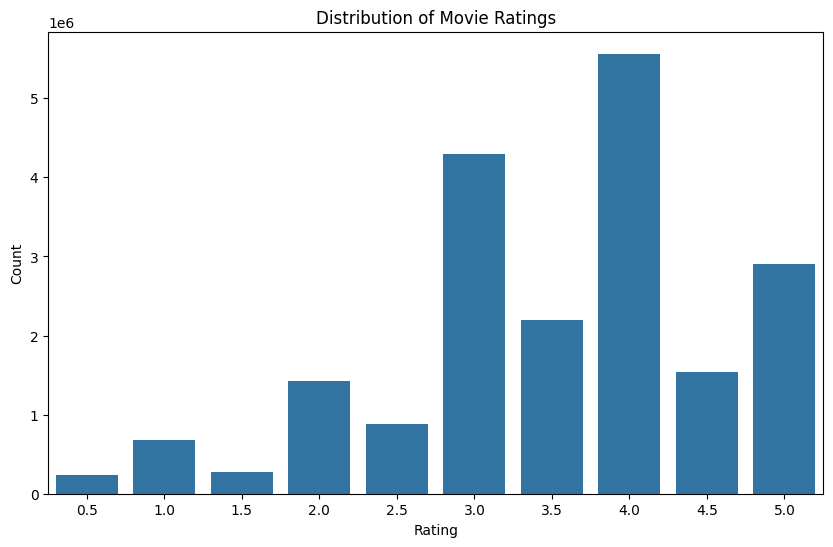

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of ratings
plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=movie_ratings)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


Visualization of Top-N Recommendations for a Specific User:

Top 10 movie recommendations for user_id: 1
          movieId                                              title  \
118992         50                         Usual Suspects, The (1995)   
389383        318                   Shawshank Redemption, The (1994)   
1937113      3030                                     Yojimbo (1961)   
3400484       858                              Godfather, The (1972)   
3441839       904                                 Rear Window (1954)   
6243078       922      Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)   
11134293    44555  Lives of Others, The (Das leben der Anderen) (...   
14399306     2019        Seven Samurai (Shichinin no samurai) (1954)   
15512538     1212                              Third Man, The (1949)   
16934428     1178                              Paths of Glory (1957)   

          est_rating  
118992      4.568714  
389383      4.514186  
1937113     4.478891  
3400484     4.467852  
3441839     4.465773  
6243078     4.456499  
11

<ipython-input-13-f66b4fa1f425>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='est_rating', y='title', data=recommendations, palette='viridis')


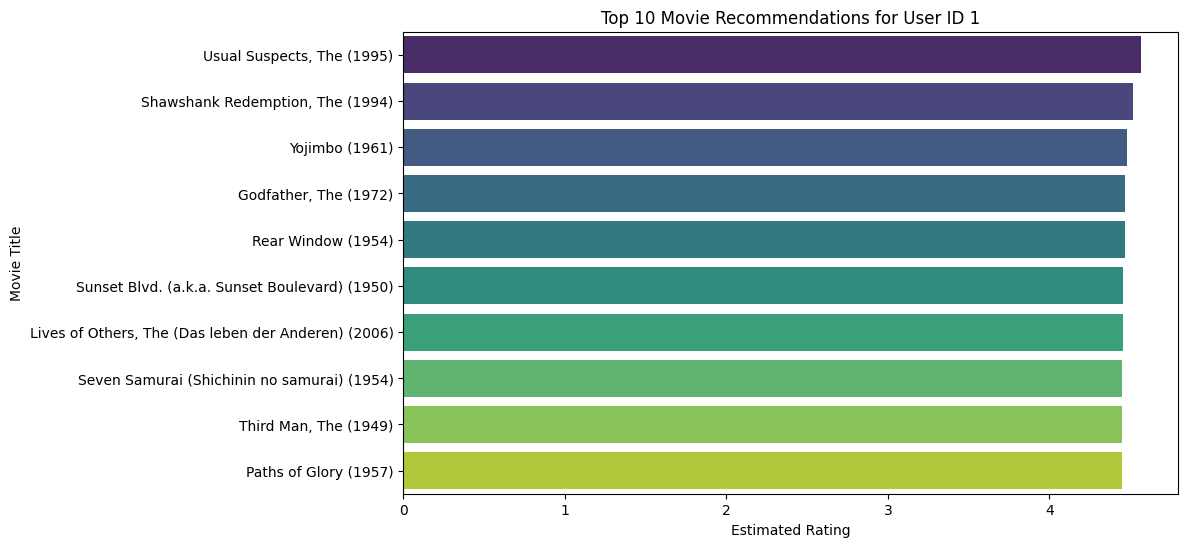

In [ ]:
def get_movie_recommendations(user_id, n_recommendations=10):
    movie_ids = movie_ratings['movieId'].unique()
    user_rated_movies = movie_ratings[movie_ratings['userId'] == user_id]['movieId']
    unrated_movies = [movie for movie in movie_ids if movie not in user_rated_movies]
    predictions = [algo.predict(user_id, movie_id) for movie_id in unrated_movies]
    recommendations = sorted(predictions, key=lambda x: x.est, reverse=True)
    top_recommendations = recommendations[:n_recommendations]
    recommended_movie_ids = [rec.iid for rec in top_recommendations]
    recommended_movies = movie_ratings[movie_ratings['movieId'].isin(recommended_movie_ids)][['movieId', 'title']].drop_duplicates()
    recommended_movies['est_rating'] = [rec.est for rec in top_recommendations]
    return recommended_movies

# Get top 10 movie recommendations for a user
user_id = 1
recommendations = get_movie_recommendations(user_id, n_recommendations=10)
print("Top 10 movie recommendations for user_id:", user_id)
print(recommendations)

# Plotting top 10 recommendations for the user
plt.figure(figsize=(10, 6))
sns.barplot(x='est_rating', y='title', data=recommendations, palette='viridis')
plt.title(f'Top 10 Movie Recommendations for User ID {user_id}')
plt.xlabel('Estimated Rating')
plt.ylabel('Movie Title')
plt.show()


Visualization of Ratings:

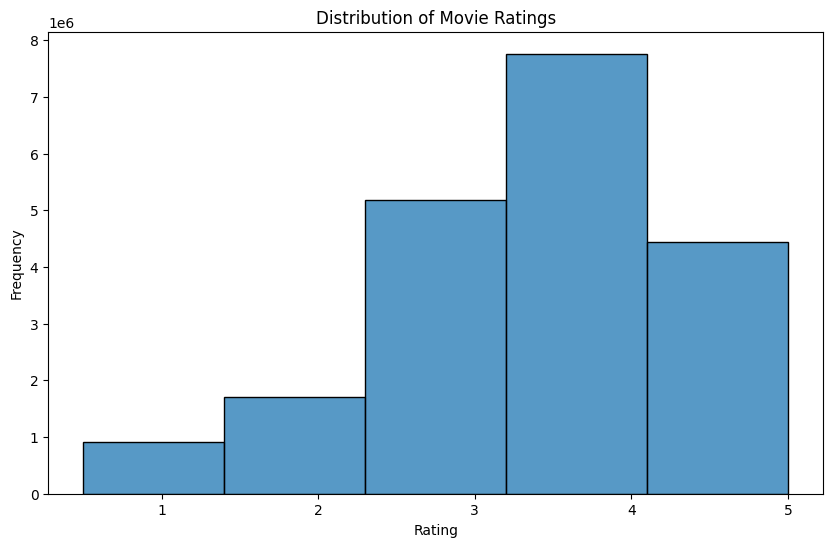

In [ ]:
# Visualize the distribution of movie ratings
plt.figure(figsize=(10, 6))
sns.histplot(movie_ratings['rating'], bins=5, kde=False)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()


Ask User Recently Watched Movie and Provide Recommendation:

In [ ]:
def get_movie_id(title, movie_metadata):
    movie_id = movie_metadata[movie_metadata['title'].str.contains(title, case=False, na=False)]['movieId'].values
    return movie_id[0] if len(movie_id) > 0 else None

def get_collaborative_recommendations(algo, user_id, movie_id, n_recommendations=10):
    movie_ids = movie_ratings['movieId'].unique()
    user_rated_movies = movie_ratings[movie_ratings['userId'] == user_id]['movieId']
    unrated_movies = [movie for movie in movie_ids if movie not in user_rated_movies]
    predictions = [algo.predict(user_id, movie_id) for movie_id in unrated_movies]
    recommendations = sorted(predictions, key=lambda x: x.est, reverse=True)
    top_recommendations = recommendations[:n_recommendations]
    recommended_movie_ids = [rec.iid for rec in top_recommendations]
    recommended_movies = movie_ratings[movie_ratings['movieId'].isin(recommended_movie_ids)][['movieId', 'title']].drop_duplicates()
    recommended_movies['estimated_rating'] = [rec.est for rec in top_recommendations]
    return recommended_movies

# Ask the user for a recently watched movie
recently_watched_movie = input("Enter the title of a recently watched movie: ")

# Find the movie ID
movie_id = get_movie_id(recently_watched_movie, movies)
if movie_id is None:
    print("Movie not found. Please try again with a different title.")
else:
    # Get collaborative filtering recommendations
    user_id = 1  # Assuming the user ID is 1 for this example
    collaborative_recommendations = get_collaborative_recommendations(algo, user_id, movie_id, n_recommendations=10)
    print("Collaborative Recommendations based on your profile:")
    print(collaborative_recommendations)


Enter the title of a recently watched movie: Nixon
Collaborative Recommendations based on your profile:
          movieId                                              title  \
118992         50                         Usual Suspects, The (1995)   
389383        318                   Shawshank Redemption, The (1994)   
1937113      3030                                     Yojimbo (1961)   
3400484       858                              Godfather, The (1972)   
3441839       904                                 Rear Window (1954)   
6243078       922      Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)   
11134293    44555  Lives of Others, The (Das leben der Anderen) (...   
14399306     2019        Seven Samurai (Shichinin no samurai) (1954)   
15512538     1212                              Third Man, The (1949)   
16934428     1178                              Paths of Glory (1957)   

          estimated_rating  
118992            4.568714  
389383            4.514186  
1937113         